In [1]:
__doc__ = """
    This file contains a basic implementation of multidigit decoding.
    It is mostly for preprocessing. The good stuff now sits in AllAtOnce_ConvNet2.
    
    This file will be deprecated soon.
"""

In [1]:
### import the required libraries
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import math
import os
import pylab as P
import skimage
import h5py
import PIL.Image as Image
import functools
from sklearn.cross_validation import train_test_split as ttsplit
import cPickle as pickle

In [2]:
try:
    print ("picking data from data_dir: {}".format(data_dir))
except:
    data_dir = os.path.split(os.getcwd())[0]
finally:
    data_path = os.path.join(data_dir, 'data')
    if not os.path.exists(data_path):
        print "please define the data_dir variable to where data sits"
        raise e

In [3]:
## the data format changes for the multiple images
## the data is stored in matlab v7.3+ and hence we need different libraries to load it

dirs = [os.path.join(data_path, dir_name) for dir_name in ['train', 'test', 'extra']]
train_file, test_file, extra_file = [os.path.join(d, 'digitStruct.mat') for d in dirs]


In [4]:
# This code is borrowed from
# https://github.com/hangyao/street_view_house_numbers/blob/master/3_preprocess_multi.ipynb
#
#
#
# The DigitStructFile is a wrapper around the h5py data.  It basically references
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data


class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]
    
    # Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [5]:
train_metadata = DigitStructFile(train_file).getAllDigitStructure_ByDigit()

In [6]:
test_metadata  = DigitStructFile(test_file).getAllDigitStructure_ByDigit()
extra_metadata = DigitStructFile(extra_file).getAllDigitStructure_ByDigit()

In [9]:
print train_metadata[0]

def get_crop(boxes):
    ## take the image
    tops = [box['top'] for box in boxes]
    heights = [box['height'] for box in boxes]
    bottoms  = [t + h for (t,h) in zip(tops, heights)]
    
    lefts = [box['left'] for box in boxes]  
    widths  = [box['width'] for box in boxes]
    rights = [l + w for (l,w) in zip(lefts, widths)]
    
    top = min(tops)
    bottom = max(bottoms)
    left = min(lefts)
    right = max(rights)
    
    return (left, top, right, bottom) #bottom-top, left, right-left)
    

def get_labels(boxes):
    return [box['label'] for box in boxes]

def extract_info(metadata):
    return (metadata['filename'], get_labels(metadata['boxes']), get_crop(metadata['boxes']))

{'boxes': [{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}], 'filename': '1.png'}


In [10]:
test_info = map(extract_info, test_metadata)
train_info = map(extract_info, train_metadata)
extra_info = map(extract_info, extra_metadata)

In [11]:
max_test_length = np.max(map(lambda t: len(t[1]), test_info))
max_train_length = np.max(map(lambda t: len(t[1]), train_info))
max_extra_length = np.max(map(lambda t: len(t[1]), extra_info))

print max_test_length, max_train_length, max_extra_length

5 6 5


In [12]:
# remove the training cases with more than 5 digits
print len(train_info)
train_info = filter(lambda t: len(t[1]) <= 5, train_info)
print len(train_info)
print len(test_info)
print len(extra_info)

33402
33401
13068
202353


In [13]:
print train_info[0]

('1.png', [1.0, 9.0], (246.0, 77.0, 419.0, 300.0))


In [14]:
## 
def read_and_process_file(file_name, crop = None, resize=True):
    
    img = Image.open(file_name)
    if crop:
        img = img.crop(crop)
    if resize:
        img = img.resize([32,32], Image.ANTIALIAS)
    ## this is temporary
    ## for lstms, we will abandon this grey scale business and use colour, font info
    img = np.dot(np.array(img, dtype='float32'), [[0.2989],[0.5870],[0.1140]]) 
    mean = np.mean(img)
    std = np.std(img)
    if std < 1e-4: 
        std = 1.
    img = (img - mean) / std
    return img

def padded_ls(ls):
    assert(len(ls) <= max_test_length)
    pad_length = max_test_length - len(ls)
    return np.array([len(ls)]+ ls + [10] * pad_length)

In [17]:
## test padded ls
#assert(padded_ls([1,9]) == [2,1,9,10,10,10])
#assert(padded_ls([2,3,5]) == [3,2,3,5,10,10])
#assert(padded_ls([1])==[1,1,10,10,10,10])
#assert(padded_ls([3,1,7,8,9]) == [5,3,1,7,8,9])

In [18]:
def fill_dataset(dir_name, image_set, label_set, enum_info):
    idx, info = enum_info
    f_name, labels, crops = info
    f_path = os.path.join(dir_name, f_name)
    image_set[idx, :, :, :] = read_and_process_file(f_path, crops)
    label_set[idx, :] = padded_ls([int(l)%10 for  l in labels])
    return True

test_dataset = np.zeros((len(test_info), 32, 32, 1), dtype=np.float32)
test_labels = np.zeros((len(test_info), 6), dtype=np.int32)

train_dataset = np.zeros((len(train_info), 32, 32, 1), dtype=np.float32)
train_labels = np.zeros((len(train_info), 6), dtype=np.int32)

extra_dataset = np.zeros((len(extra_info), 32, 32, 1), dtype=np.float32)
extra_labels = np.zeros((len(extra_info), 6), dtype=np.int32)

make_train_dataset = functools.partial(fill_dataset, dirs[0], train_dataset, train_labels)
make_test_dataset = functools.partial(fill_dataset, dirs[1], test_dataset, test_labels)
make_extra_dataset = functools.partial(fill_dataset, dirs[2], extra_dataset, extra_labels)

In [19]:
## test the function to make sure we can use it
train_worked = map(make_train_dataset, enumerate(train_info))
test_worked  = map(make_test_dataset, enumerate(test_info))
extra_worked = map(make_extra_dataset, enumerate(extra_info))

In [20]:
assert(all(train_worked))
assert(all(test_worked))
assert(all(extra_worked))

In [21]:
print train_dataset.shape
print test_dataset.shape
print extra_dataset.shape

print train_labels.shape
print test_labels.shape 
print extra_labels.shape

(33401, 32, 32, 1)
(13068, 32, 32, 1)
(202353, 32, 32, 1)
(33401, 6)
(13068, 6)
(202353, 6)


In [22]:
train_dataset = np.transpose(train_dataset, (0, 2, 1, 3))
test_dataset = np.transpose(test_dataset, (0, 2, 1, 3))
extra_dataset = np.transpose(extra_dataset, (0, 2, 1, 3))

In [23]:
print train_dataset.shape
print test_dataset.shape
print extra_dataset.shape

print train_labels.shape
print test_labels.shape 
print extra_labels.shape

(33401, 32, 32, 1)
(13068, 32, 32, 1)
(202353, 32, 32, 1)
(33401, 6)
(13068, 6)
(202353, 6)


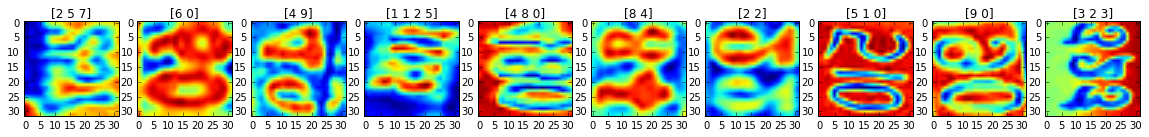

In [24]:
## cleaned up the labels for use -> now, let's work work with the images themselves
## The vector is provided 32, 32, 3, 73257 -> let's see how this looks

display_size  = 10
rand_indices = np.random.randint(0, train_dataset.shape[0], size=display_size)
fig = P.figure(figsize=(20, 20))
for idx in range(len(rand_indices)):
    orig_idx = rand_indices[idx]
    a=fig.add_subplot(1,display_size,idx+1)
    P.imshow(train_dataset[orig_idx,:,:,0])
    a.set_title(str(train_labels[orig_idx, 1:1+train_labels[orig_idx, 0]])) #rand_indices[idx, 0]]]]))
    

In [25]:
## nice! now we can split the train images, train_data into a train and validation test set
## we will use the test data as is
## select some of the train dataset  as validation set

train_images_1, valid_images_1, train_labels_1, valid_labels_1 = \
    ttsplit(train_dataset, train_labels, test_size=0.15, random_state=7)
    

In [26]:
print train_images_1.shape
print train_images_1.dtype
print train_labels_1.shape
print train_labels_1.dtype

print valid_images_1.shape
print valid_images_1.dtype
print valid_labels_1.shape
print valid_labels_1.dtype

print test_dataset.shape
print test_dataset.dtype
print test_labels.shape
print test_labels.dtype

(28390, 32, 32, 1)
float32
(28390, 6)
int32
(5011, 32, 32, 1)
float32
(5011, 6)
int32
(13068, 32, 32, 1)
float32
(13068, 6)
int32


In [27]:
train_images_2, valid_images_2, train_labels_2, valid_labels_2 = \
    ttsplit(extra_dataset, extra_labels, test_size=0.005, random_state=7)

In [28]:
print train_images_2.shape
print train_images_2.dtype
print train_labels_2.shape
print train_labels_2.dtype

print valid_images_2.shape
print valid_images_2.dtype
print valid_labels_2.shape
print valid_labels_2.dtype


(201341, 32, 32, 1)
float32
(201341, 6)
int32
(1012, 32, 32, 1)
float32
(1012, 6)
int32


In [29]:
train_images = np.concatenate((train_images_1, train_images_2), axis=0)
train_labels = np.concatenate((train_labels_1, train_labels_2), axis=0)
valid_images = np.concatenate((valid_images_1, valid_images_2), axis =0)
valid_labels = np.concatenate((valid_labels_1, valid_labels_2), axis = 0)
test_images  = test_dataset

In [30]:
print train_images.shape
print train_images.dtype
print train_labels.shape
print train_labels.dtype

print valid_images.shape
print valid_images.dtype
print valid_labels.shape
print valid_labels.dtype

print test_images.shape
print test_images.dtype
print test_labels.shape
print test_labels.dtype

(229731, 32, 32, 1)
float32
(229731, 6)
int32
(6023, 32, 32, 1)
float32
(6023, 6)
int32
(13068, 32, 32, 1)
float32
(13068, 6)
int32


In [31]:
def randomize(images, labels):
    assert(images.shape[0] == labels.shape[0])
    perm = np.random.permutation(images.shape[0])
    return images[perm], labels[perm]

In [32]:
valid_images, valid_labels = randomize(valid_images, valid_labels)
#test_images, test_labels = randomize(test_images, test_labels)
train_images, train_labels = randomize(train_images, train_labels)

### Run the Model

In [33]:
## always start a model with what you are going to measure it by
def accuracy(predictions, labels):
    """
        How many places did we get right?
        TODO: This should be a longest common substring match instead of positional matching?
    """
    #assert(predictions.shape[0] == len(labels))
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels)) / labels.size

In [46]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
image_size = 32
num_channels = 1
num_labels = 11 ## we have a blank space

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
  tf_valid_dataset = tf.constant(valid_images)
  tf_test_dataset = tf.constant(test_images)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)) ## 5 x 5 x 1 x 16 -> 28 x 28 x 1 x 16
  layer1_biases = tf.Variable(tf.zeros([depth]))

  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))       ## 5 x 5 x 16 x 16 -> 24 x 24 x 16 x 16
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

  layer3_weights = tf.Variable(tf.truncated_normal(
      #[image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)) 
    [patch_size * patch_size * depth, num_hidden], stddev=0.1)) 
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  ## create 5 predictors here for the five places
  
  op1_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  op2_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  op3_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  op4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  op5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


  # Model.
  def model(data, is_training = False):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.avg_pool(conv, [1, 4, 4, 1], [1,2,2,1], padding = 'SAME')
    hidden = tf.nn.relu(pool + layer1_biases)
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='VALID')
    pool = tf.nn.max_pool(conv, [1,1,1,1], [1,1,1,1], padding = 'SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    if is_training:
        hidden  = tf.nn.dropout(hidden, keep_prob=0.5)

    digit_1 = tf.matmul(hidden, op1_weights) + op1_biases
    digit_2 = tf.matmul(hidden, op2_weights) + op2_biases
    digit_3 = tf.matmul(hidden, op3_weights) + op3_biases
    digit_4 = tf.matmul(hidden, op4_weights) + op4_biases
    digit_5 = tf.matmul(hidden, op5_weights) + op5_biases
    
    return (digit_1, digit_2, digit_3, digit_4, digit_5)

  
  # Training computation.
  d1, d2, d3, d4, d5 = model(tf_train_dataset, True)
  loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(d1, tf_train_labels[:,1])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d2, tf_train_labels[:,2])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d3, tf_train_labels[:,3])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d4, tf_train_labels[:,4])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d5, tf_train_labels[:,5])
    )
    
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
    
  # increasing steps to 35001, decay steps to 250 -> 95.2

  learning_rate = tf.train.exponential_decay(0.15, global_step, 300, 0.99)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(d) for d in [d1, d2, d3, d4, d5]])
  valid_model  = model(tf_valid_dataset)
  valid_prediction = tf.pack([tf.nn.softmax(valid_model[idx]) for idx in range(5)]) #d in [valid_model]])
  test_model  = model(tf_test_dataset)
  test_prediction = tf.pack([tf.nn.softmax(test_model[idx]) for idx in range(5)])

In [47]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_images[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels[:,1:6]))
  final_predictions = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(final_predictions, test_labels[:,1:6]))

Initialized
Minibatch loss at step 0: 21.500786
Minibatch accuracy: 6.2%
Validation accuracy: 57.9%
Minibatch loss at step 2500: 5.359865
Minibatch accuracy: 67.5%
Validation accuracy: 70.9%
Minibatch loss at step 5000: 4.901175
Minibatch accuracy: 66.2%
Validation accuracy: 74.2%
Minibatch loss at step 7500: 5.076679
Minibatch accuracy: 68.8%
Validation accuracy: 75.4%
Minibatch loss at step 10000: 4.206007
Minibatch accuracy: 70.0%
Validation accuracy: 73.9%
Minibatch loss at step 12500: 5.656655
Minibatch accuracy: 62.5%
Validation accuracy: 76.0%
Minibatch loss at step 15000: 4.425024
Minibatch accuracy: 66.2%
Validation accuracy: 77.8%
Minibatch loss at step 17500: 4.175624
Minibatch accuracy: 68.8%
Validation accuracy: 78.6%
Minibatch loss at step 20000: 4.268687
Minibatch accuracy: 68.8%
Validation accuracy: 80.6%
Minibatch loss at step 22500: 4.688572
Minibatch accuracy: 65.0%
Validation accuracy: 81.6%
Minibatch loss at step 25000: 3.621759
Minibatch accuracy: 75.0%
Validation

In [ ]:
predictions = np.argmax(final_predictions, 2).T

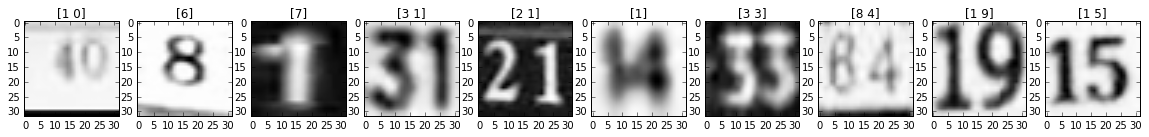

In [72]:
rand_indices = np.random.randint(0, test_images.shape[0], size=display_size)
fig = P.figure(figsize=(20, 20))
for idx in range(len(rand_indices)):
    orig_idx = rand_indices[idx]
    a=fig.add_subplot(1,display_size,idx+1)
    P.imshow(test_images[orig_idx,:,:,0].T, cmap='Greys_r')
    img_prediction  = predictions[orig_idx,:]
    a.set_title(str(img_prediction[img_prediction != 10]))

In [52]:
train_images_pickle_f_name = os.path.join(data_dir, 'train_images.pkl')
test_images_pickle_f_name = os.path.join(data_dir, 'test_images.pkl')
valid_images_pickle_f_name = os.path.join(data_dir, 'valid_images.pkl')

train_labels_pickle_f_name = os.path.join(data_dir, 'train_labels.pkl')
test_labels_pickle_f_name = os.path.join(data_dir, 'test_labels.pkl')
valid_labels_pickle_f_name = os.path.join(data_dir, 'valid_labels.pkl')


def write_pickle(f_name, dataset):
    if not os.path.exists(f_name):
        f = open(f_name, 'w')
        pickle.dump(dataset, f)
        f.close()
    

In [55]:
train_bundle = {'X': train_images, 'y': train_labels}
test_bundle = {'X': test_images, 'y': test_labels}
valid_bundle = {'X': valid_images, 'y': valid_labels}

In [56]:
write_pickle(train_images_pickle_f_name, train_bundle)
write_pickle(test_images_pickle_f_name, test_bundle)
write_pickle(valid_images_pickle_f_name, valid_bundle)
